In [1]:
import pandas as pd
import numpy as np
# import cupy as np
import plotly.express as px
import pandas_market_calendars as mcal
from tqdm.notebook import tqdm

## Payoff Function

In [2]:
def payoff(paths, K, Barrier, ratio):
    Nsim = paths.shape[0]
    final_prices = paths[:, :, -1] #S_T
    above_strike = np.all(final_prices >= K, axis=1)
    barrier_event = np.any(paths.min(axis=2) <= Barrier, axis=1)

    # No barrier event or (barrier event and above strike)
    cash_payout = np.where(np.logical_or(np.logical_not(barrier_event), np.logical_and(barrier_event,  above_strike)), 1105, 0)

    # barrier event and below strike
    percent_change = final_prices / K # Based on final strike price
    min_loc = np.argmin(percent_change, axis=1) # Finding the worst performing underlying
    j = np.indices(min_loc.shape)
    payouts = 1000 * percent_change[j, min_loc] + 105 # certificate to stock ratio * final price of the stock + coupon payment
    stock_payout = np.where(np.logical_and(barrier_event,  np.logical_not(above_strike)), payouts, 0)

    return np.sum(np.concatenate((cash_payout.reshape(1, Nsim), stock_payout.reshape(1, Nsim))), axis=0)

Expected Payoff: $ \hat{f}(S, t) = \frac{1}{n} \sum^n_{i=1} e^{-r(T-t)} \chi(S^{(i)})$

In [3]:
def expected_payoff(payoffs, r, T, t):
    return np.mean(np.exp(-r*(T-t)) * payoffs)

## Plotting

In [4]:
def plot_simulations(price_hist, Nsim, sim_paths, stock=0):
    """plots simulations for chosen stock

    Args:
        price_hist (df): df of historical prices
        sim_paths (list): simulated price paths
        stock (int, optional): index of stock. Defaults to 0.
    """
    # df of historical prices
    price_hist = price_hist.to_numpy()[:, [0]].reshape(-1)
    price_hist = np.vstack([price_hist]*Nsim)
    price_hist = pd.DataFrame(price_hist).transpose()

    sim_paths = pd.DataFrame(sim_paths[:, stock, :]).transpose()
    sim_paths = pd.concat((price_hist, sim_paths))
    sim_paths = sim_paths.reset_index(drop=True)
    fig = px.line(sim_paths)
    return fig

# GBM Simlulations


## Standard MC

In [36]:
def multi_asset_GBM(S0, v, Sigma, dt, m, p):
    """GBM simulation of multiple asset paths

    Args:
        S0 (vector of start prices): vector of starting prices
        v (array): mu/dt
        Sigma (matrix): covariance matrix
        dt (float): delta between each time step
        m (int): number of days simulated
        p (int): number of assets
    """

    S = np.zeros(shape=(m, p))
    S[0] = S0

    z = np.random.multivariate_normal(mean=np.zeros(p), cov=np.identity(p), size=m)
    # z = np.random.multivariate_normal(mean=v*dt, cov=Sigma*dt, size=m)
    for step in range(1, m):
        r = calc_rates(step, m, rates)
        S[step] = S[step-1] * np.exp(( r * dt * np.ones(p) ) # Rate discount
             - ( 0.5 * dt * np.diagonal(Sigma) ) # Volatility
             + ( np.matmul(np.linalg.cholesky(Sigma * dt), z[step-1]) )) # Weiner process
        # S[step] = np.exp(np.log(S[step-1]) + z[step-1])
    return np.transpose(S)

## Antithetic Variate

In [37]:
def multi_asset_GBM_av(S0, v, Sigma, dt, m, p):
    """GBM simulation of multiple asset paths

    Args:
        S0 (vector of start prices): vector of starting prices
        v (array): mu/dt
        Sigma (matrix): covariance matrix
        dt (float): delta between each time step
        m (int): number of days simulated
        p (int): number of assets
    """

    S = np.zeros(shape=(m, p))
    Stilde = np.zeros(shape=(m, p))
    S[0] = S0
    Stilde[0] = S0

    z = np.random.multivariate_normal(mean=np.zeros(p), cov=np.identity(p), size=m)
    # z = np.random.multivariate_normal(mean=v*dt, cov=Sigma*dt, size=m)
    for step in range(1, m):
        r = calc_rates(step, m, rates)
        S[step] = S[step-1] * np.exp(( r * dt * np.ones(p) ) # Rate discount
             - ( 0.5 * dt * np.diagonal(Sigma) ) # Volatility
             + ( np.matmul(np.linalg.cholesky(Sigma * dt), z[step-1]) )) # Weiner process

        Stilde[step] = S[step-1] * np.exp(( r * dt * np.ones(p) ) # Rate discount
             - ( 0.5 * dt * np.diagonal(Sigma) ) # Volatility
             + ( np.matmul(np.linalg.cholesky(Sigma * dt), -z[step-1]) )) # Weiner process
        # S[step] = np.exp(np.log(S[step-1]) + z[step-1])
        # Stilde[step] = np.exp(np.log(Stilde[step-1]) - z[step-1])
    return np.transpose(S), np.transpose(Stilde)

## Helper Functions

In [7]:
# function to get v and Sigma from within a 1 year window
def get_simulation_params(asset_hist, t, lifetime, dt):
    prices = asset_hist[t: t+252, :]
    log_returns = np.diff(np.log(prices), axis=0)
    S0 = prices[-1, :]
    v = np.mean(log_returns, axis=0)/dt
    Sigma = np.cov(log_returns, rowvar=False)/dt
    return S0, Sigma, v

In [46]:
def n_path_sim(asset_hist, Nsim, t, lifetime, dt, p, m, sim_func, var_reduction=None):

    paths = None
    remaining_steps = m-t

    if var_reduction == None:
        paths = np.zeros(shape=(Nsim, p, remaining_steps))
        for i in range(Nsim):
            S0, Sigma, v = get_simulation_params(asset_hist, t, lifetime, dt)
            paths[i] = sim_func(S0, v, Sigma, dt, remaining_steps, p)

    elif var_reduction == "av":
        paths = np.zeros(shape=(2 * Nsim, p, remaining_steps))
        for i in range(Nsim):
            S0, Sigma, v = get_simulation_params(asset_hist, t, lifetime, dt)
            paths[i], paths[Nsim + i] = sim_func(S0, v, Sigma, dt, remaining_steps, p)

    return paths


In [9]:
def calc_rates(t, m, rates):
    if t + 251 < len(rates):
        rates_today = rates[t + 251]
    else:
        rates_today = rates[-1]
    time_frame = np.array([21, 42, 63, 126, 252, 504])
    return np.interp(40, time_frame, rates_today)

# Run Simulations

In [10]:
df = pd.read_csv("assets.csv", index_col='Date', parse_dates=True)
df.head()

,CVX,UNH,XOM
Date,,,
2020-05-26,93.300003,294.890015,45.910000
2020-05-27,93.900002,303.769989,46.240002
2020-05-28,90.870003,303.970001,45.040001
2020-05-29,91.699997,304.850006,45.470001
2020-06-01,92.790001,305.929993,46.279999


In [11]:
rates_df = pd.read_csv("rates.csv", index_col='Date', parse_dates=True)
rates_df.head()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr
Date,,,,,,
2020-05-26,0.10,0.12,0.14,0.17,0.17,0.18
2020-05-27,0.11,0.14,0.15,0.17,0.18,0.19
2020-05-28,0.14,0.15,0.15,0.18,0.17,0.17
2020-05-29,0.13,0.14,0.14,0.18,0.17,0.16
2020-06-01,0.12,0.14,0.14,0.18,0.17,0.14


In [12]:
actual_prices = pd.read_csv("actual.csv")

In [13]:
# Create a calendar
nyse = mcal.get_calendar('NYSE')

# set vars for product lifetime
initial_fixing = pd.to_datetime("2021-05-25")
maturity = pd.to_datetime("2022-11-29")
lifetime = nyse.schedule(start_date=initial_fixing, end_date=maturity).index

# if using cupy, move data to GPU
asset_hist = np.asarray(df.to_numpy())
rates = np.asarray(rates_df.to_numpy()) / 100

# gathered from product description
K = np.array([103.87, 413.05, 58.26])
Barrier = np.array([62.322, 247.830, 34.956])
ratio = np.array([9.6274, 2.4210, 17.1644])

asset_hist = asset_hist / K
Barrier = Barrier / K
K = K / K

m = len(lifetime)  # no of days product is active for 
T = m/252 # period in terms of no. of financial years
dt = 1/252  # daily increment

In [42]:
S0, Sigma, v = get_simulation_params(asset_hist, 30, lifetime, dt)
test_paths = multi_asset_GBM(S0, v, Sigma, dt, m-30, 3)

In [43]:
test_df = pd.DataFrame(data=test_paths.T, columns=["Stock 1", "stock 2", "stock 3"])
test_df.head()

,Stock 1,stock 2,stock 3
0,0.990950,0.996635,1.036904
1,0.953745,0.985172,1.016479
2,0.957205,1.016870,1.018144
3,0.986890,1.035528,1.040945
4,1.010113,1.044072,1.078487


In [44]:
px.line(test_df)

In [47]:
# ROLLING WINDOW OVER ENTIRE LIFETIME
# uses newest asset prices on current day to get expected payoff for that day
# make sure to run previous cell before running this one
expected_payoffs = np.zeros(shape=(2, m))

def simulate(t, sim_func, var_reduction):

    paths = n_path_sim(asset_hist=asset_hist,
                    Nsim=50,
                    t=t,
                    lifetime=lifetime,
                    dt=dt,
                    p=3,
                    m=m,
                    sim_func=sim_func,
                    var_reduction=var_reduction
                    )
                    
    r = calc_rates(t, m, rates)
    return t, expected_payoff(payoff(paths, K, Barrier, ratio), r=r, T=T, t=t*dt)


for i, (sim_func, var_reduction) in enumerate( tqdm( [(multi_asset_GBM, None), (multi_asset_GBM_av, "av")] ) ):
    for t in tqdm(range(m), leave=False):
        _, result = simulate(t, sim_func, var_reduction)
        expected_payoffs[i][t] = result

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

In [48]:
simulated_prices = pd.DataFrame(data=expected_payoffs.T, columns=["Monte Carlo", "Antithetic Variates"])

In [49]:
merged = pd.concat([actual_prices, simulated_prices], axis=1)

In [50]:
px.line(merged, y=["Price", "Monte Carlo", "Antithetic Variates"])

<AxesSubplot:xlabel='Date'>

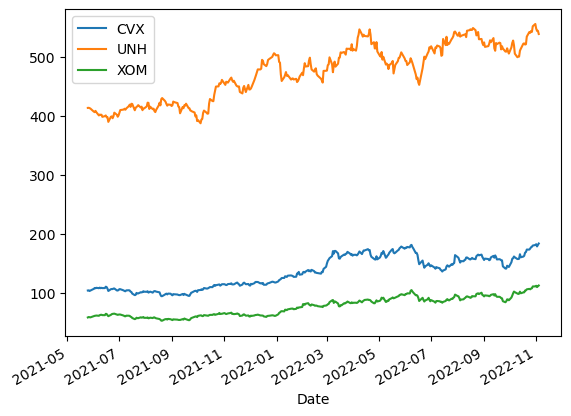

In [32]:
df.loc[lifetime[0]:].plot()